In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import time

In [3]:
from itertools import groupby

In [4]:
clicks = pd.read_csv('/Users/lavishajindal/coding/git/ConMind/data/JD_click_data.csv')

## Clean click data


In [31]:
# Remove all rows with User_ID = '-'

clicks = clicks[clicks.user_ID != '-']

In [104]:
# extract all user_IDs, select only unique ones, sort them 

users = clicks.user_ID
users = users.unique()
users.sort()
len(users)

2557836

## Sorting method to reduce click-stream data into a 1d list

In [ ]:
# This cell takes ___ mins to execute

c = clicks.drop(['channel'],axis=1)
c = c.sort_values(by=['user_ID']).reset_index(drop=True)
c.head(10)

In [813]:
# Import from presaved pickles
c = pd.read_pickle('./sorted_user_ID_reqtime.pkl')

In [327]:
# using the last index, we create a dataframe with 1d list of n first elements of users
#takes around 3 mins for 100,000 rows of data

ind = 0
#liss=[]
n = 100000
for i in range(0,n,1):
    pu = users[i]
    #try:
    c1 = c[ind:ind+1100]
    ind = c1.loc[c1['user_ID']==pu].index[-1]  
    liss.append([list(c1.loc[c1['user_ID']==pu].request_time)])

df = pd.DataFrame(liss, index=users[:100000], columns=['A'])

'Mon Jan 20 18:18:46 2020'

In [815]:
df

,A
00000e0594,"[2018-03-30 11:00:17, 2018-03-30 11:25:24, 201..."
000014394e,"[2018-03-01 17:58:57, 2018-03-01 17:59:30, 201..."
00001dce11,[2018-03-07 08:33:38]
00002a195f,"[2018-03-06 22:49:39, 2018-03-06 22:53:48, 201..."
000035ae42,"[2018-03-14 06:29:29, 2018-03-14 06:32:29]"
...,...
09f678e7de,"[2018-03-16 11:00:56, 2018-03-16 11:01:17]"
09f687b120,[2018-03-20 13:54:29]
09f687dac1,"[2018-03-15 14:54:00, 2018-03-15 14:55:03, 201..."
09f688587e,[2018-03-30 14:43:05]


In [816]:
#check it has read the large lists properly 

len(df.loc[df.index == '004b21b477'].values[0][0])

270

## Click-time distribution
Expecting a bi-modal distribution for how much time users spend on each click

In [817]:
#This cell takes less than a minute to execute with 100k users

click_per_user=[]
longer_users = []
for j in users[:100000]:
    click_per_user.append(len(df.loc[j].to_numpy()[0]))
    if len(df.loc[j].to_numpy()[0]) >=200:
        longer_users.append(j)

(0, 200)

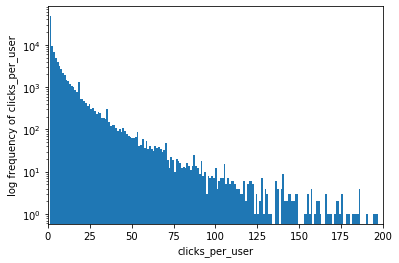

In [415]:
hist(click_per_user,1000)
yscale('log')
ylabel('log frequency of clicks_per_user')
xlabel('clicks_per_user')
xlim([0,200])

## Breaking up long time_list into smaller sessions

In [422]:
from datetime import datetime

In [510]:
list_times = df.loc[df.index == '09e05d258b'].values[0][0]

In [511]:
list_times.sort()

In [512]:
list_times[:5]

['2018-03-06 16:08:56',
 '2018-03-06 16:08:56',
 '2018-03-06 16:09:01',
 '2018-03-06 16:09:01',
 '2018-03-06 16:09:05']

In [513]:
list_times = unique(list_times)

In [514]:
list_times[:5]

['2018-03-06 16:08:56',
 '2018-03-06 16:09:01',
 '2018-03-06 16:09:05',
 '2018-03-06 16:09:08',
 '2018-03-06 16:09:14']

In [521]:
indent = []
for i,j in enumerate(list_times):
    try:
        a,b = datetime.strptime(j, '20%y-%m-%d %H:%M:%S'),datetime.strptime(list_times[i+1], '20%y-%m-%d %H:%M:%S')
        c1 = b-a
        if c1.days >0 or c1.seconds >=1200:
            indent.append(i+1)           
    except IndexError:
        continue

In [525]:
# Breaking up into smaller sessions
lol = []
n=0
for i in range(0,len(indent),1):
    lol.append(list_times[n:indent[i]])
    n=indent[i]
lol.append(list_times[indent[i]:])

In [494]:
def len_(l):  #returns the length of each element in a list of lists
    res=[]
    for j in l:
        res.append(len(j))
    return(res)

## Click-frequency distribution
This is after each user's clickstream has been split up into sessions 

In [563]:
# This cell takes 1-5-30 mins to execute 100,10000,100000 data points

click_per_user=[]
for j in users[:100000]:
        
    list_times = df.loc[df.index == j].values[0][0]
    list_times.sort()
    list_times = unique(list_times)
        
    indent = []
    for i,k in enumerate(list_times):
        try:
            a,b = datetime.strptime(k, '20%y-%m-%d %H:%M:%S'),datetime.strptime(list_times[i+1], '20%y-%m-%d %H:%M:%S')
            c1 = b-a
            if c1.days >0 or c1.seconds >=1200:
                indent.append(i+1)           
        except IndexError:
            continue
    
    if indent == []:
        click_per_user.append(len(df.loc[j].to_numpy()[0]))
    else:       
        lol = []
        n=0
        for i in range(0,len(indent),1):
            lol.append(list_times[n:indent[i]])
            n=indent[i]
        lol.append(list_times[indent[i]:])
        click_per_user = click_per_user+len_(lol)
        

In [565]:
len(click_per_user)

194396

Text(0.5, 0, 'clicks_per_user')

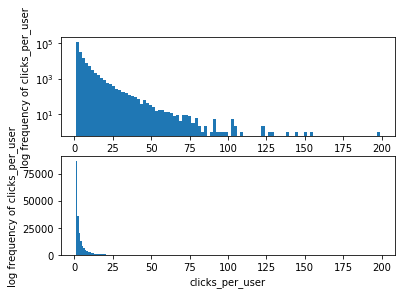

In [574]:

subplot(211)
hist(click_per_user,100)
yscale('log')
ylabel('log frequency of clicks_per_user')
xlabel('clicks_per_user')

subplot(212)
hist(click_per_user,200)

ylabel('log frequency of clicks_per_user')
xlabel('clicks_per_user')

#xlim([0,50])

Text(0.5, 0, 'clicks_per_user')

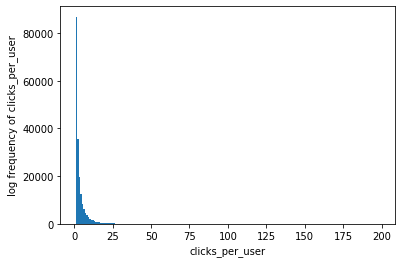

In [576]:
#result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))
hist(click_per_user,200)

ylabel('log frequency of clicks_per_user')
xlabel('clicks_per_user')


## Explore the features of some longer clicktime users

We have extracted some longer users from the click through data and we will break them into smaller sessions and create a custom dataframe that has the following properties.   

index = numbered for easy reference      
column1 = user_ID   
column2 = sorted number for which of their sessions it is   
column3 = click_stream list for that session   
column4 = product_stream list for what they were viewing in that session   
   
len(col3) == len(col4)


In [818]:
# completing the above for 1 user: pu
pu = longer_users[1]
list_times = df.loc[df.index == pu].values[0][0]

# Obtain product stream for this same 1 user: pu


In [819]:
prod_list = c[c.user_ID == pu].sort_values(by=['request_time']).sku_ID

#remove duplicates for which prod_i=prod_j AND time_i=time_j 

trail_df = pd.DataFrame(transpose([list_times,prod_list]),index=arange(0,len(list_times),1),columns = ['Time','Prod'])
trail = trail_df.drop_duplicates().reset_index(drop=True)

In [821]:
#obtain number of sessions:

lot=[]
lop=[]
snl=[]
n=0 #session counter
t_=[]
p_=[]
a = datetime.strptime(trail.Time[0],'20%y-%m-%d %H:%M:%S')
for i,j in enumerate(trail.Time):
    b = datetime.strptime(j,'20%y-%m-%d %H:%M:%S')
    t_.append(j)
    p_.append(trail.Prod[i])
    c1 = b-a
    a = b
    if c1.days >0 or c1.seconds >=1200:
        lot.append(t_[:-1])
        lop.append(p_[:-1])
        snl.append(len(t_[:-1]))
        t_=[j]
        p_=[trail.Prod[i]]
        n=n+1

In [822]:
fin = pd.DataFrame(transpose([[pu]*n,arange(1,n+1,1),snl,lot,lop]),index = arange(1,n+1,1) ,columns=['User','Session_ID','Session_Len','Times','Prods'])

In [835]:
fin.sort_values(by=['Times']).tail()

,User,Session_ID,Session_Len,Times,Prods
17,004c132a3f,17,5,"[2018-03-22 16:39:23, 2018-03-22 16:40:06, 201...","[8dc4a01dec, 068f4481b3, 067b673f2b, 067b673f2..."
18,004c132a3f,18,8,"[2018-03-26 12:42:24, 2018-03-26 12:42:55, 201...","[068f4481b3, f7280c119d, e99eb7d131, 068f4481b..."
19,004c132a3f,19,3,"[2018-03-27 13:27:07, 2018-03-27 13:27:51, 201...","[adfedb6893, c4ea4afceb, 068f4481b3]"
20,004c132a3f,20,39,"[2018-03-27 22:53:44, 2018-03-27 22:57:43, 201...","[589c2b865b, 9ab7657395, c4858d9437, 159aae0d4..."
21,004c132a3f,21,62,"[2018-03-28 09:32:53, 2018-03-28 09:33:09, 201...","[39235e5f8e, 8137017cc6, ecc00df0b6, a6fd4d931..."


In [836]:
xx = fin.sort_values(by=['Times'])

In [837]:
for i,j in zip(list(xx.Times)[-1],list(xx.Prods)[-1]):
    print(i,j)

2018-03-28 09:32:53 39235e5f8e
2018-03-28 09:33:09 8137017cc6
2018-03-28 09:33:24 ecc00df0b6
2018-03-28 09:33:40 a6fd4d9313
2018-03-28 09:34:07 b10b452ea9
2018-03-28 09:34:34 1b3f5d4d21
2018-03-28 09:34:42 2ce44c54aa
2018-03-28 09:35:05 a6fd4d9313
2018-03-28 09:37:05 4d380cf119
2018-03-28 09:38:36 56b746bd59
2018-03-28 09:43:10 56b746bd59
2018-03-28 09:57:25 81e57cbc50
2018-03-28 09:57:35 589c2b865b
2018-03-28 09:57:53 c56544784c
2018-03-28 09:57:58 c4ea4afceb
2018-03-28 09:58:04 a6fd4d9313
2018-03-28 09:58:21 ecc00df0b6
2018-03-28 10:04:27 56b746bd59
2018-03-28 10:04:50 81047a4426
2018-03-28 10:05:19 c4a9baeb24
2018-03-28 10:05:27 e380629463
2018-03-28 10:07:03 ccb546f72d
2018-03-28 10:12:49 81e57cbc50
2018-03-28 10:12:55 068f4481b3
2018-03-28 10:13:05 2523d051fd
2018-03-28 10:13:13 2523d051fd
2018-03-28 10:13:20 c56544784c
2018-03-28 10:14:18 a6fd4d9313
2018-03-28 10:14:46 589c2b865b
2018-03-28 10:14:59 56b746bd59
2018-03-28 10:16:40 2ddb64e05a
2018-03-28 10:16:44 2ddb64e05a
2018-03-

In [838]:
prods=list(xx.Prods)[-1]

d = dict([(y,x+1) for x,y in enumerate(sorted(set(prods)))])    
uni=[d[x] for x in list(xx.Prods)[-1]]
for i,j in zip(prods,uni):
    print(i,j)

39235e5f8e 11
8137017cc6 20
ecc00df0b6 31
a6fd4d9313 23
b10b452ea9 24
1b3f5d4d21 4
2ce44c54aa 7
a6fd4d9313 23
4d380cf119 13
56b746bd59 14
56b746bd59 14
81e57cbc50 21
589c2b865b 15
c56544784c 27
c4ea4afceb 26
a6fd4d9313 23
ecc00df0b6 31
56b746bd59 14
81047a4426 19
c4a9baeb24 25
e380629463 30
ccb546f72d 28
81e57cbc50 21
068f4481b3 2
2523d051fd 5
2523d051fd 5
c56544784c 27
a6fd4d9313 23
589c2b865b 15
56b746bd59 14
2ddb64e05a 8
2ddb64e05a 8
56b746bd59 14
345e86916d 9
28d5600aac 6
d1e650797b 29
56b746bd59 14
81e57cbc50 21
589c2b865b 15
7f947c0055 18
f5b527bb09 32
34dc7f6d80 10
7f53769d3f 17
9cfecca1a4 22
9cfecca1a4 22
9cfecca1a4 22
56b746bd59 14
f5b527bb09 32
56b746bd59 14
56b746bd59 14
9cfecca1a4 22
28d5600aac 6
7f947c0055 18
7f947c0055 18
6d547e6db9 16
1a2362c248 3
b10b452ea9 24
3a64d9667a 12
067b673f2b 1
3a64d9667a 12
fbce41fd82 33
3a64d9667a 12


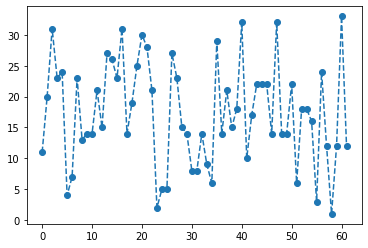

In [841]:
# Display the clicking 

plot(uni,'o--')
#delta = 2*pi/max(uni)


(array([1., 1., 1., 1., 2., 2., 1., 2., 1., 1., 1., 3., 1., 9., 3., 1., 1.,
        3., 1., 1., 3., 4., 4., 2., 1., 1., 2., 1., 1., 1., 2., 2., 1.]),
 array([ 1.        ,  1.96969697,  2.93939394,  3.90909091,  4.87878788,
         5.84848485,  6.81818182,  7.78787879,  8.75757576,  9.72727273,
        10.6969697 , 11.66666667, 12.63636364, 13.60606061, 14.57575758,
        15.54545455, 16.51515152, 17.48484848, 18.45454545, 19.42424242,
        20.39393939, 21.36363636, 22.33333333, 23.3030303 , 24.27272727,
        25.24242424, 26.21212121, 27.18181818, 28.15151515, 29.12121212,
        30.09090909, 31.06060606, 32.03030303, 33.        ]),
 <a list of 33 Patch objects>)

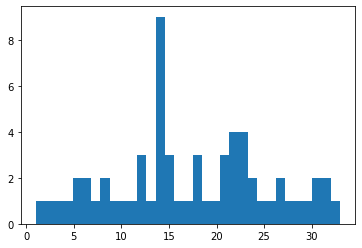

In [843]:
hist(uni,max(uni))

In [5]:
orders = pd.read_csv('/Users/lavishajindal/coding/git/ConMind/data/JD_order_data.csv')

In [840]:
orders[orders.user_ID==pu]

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type,promise,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des
482721,b20ac9ddd1,004c132a3f,f5b527bb09,2018-03-28,2018-03-28 11:16:40.0,1,1,1,69.0,52.0,4.0,13.0,0.0,0.0,0,4,4
482731,b20ac9ddd1,004c132a3f,9cfecca1a4,2018-03-28,2018-03-28 11:16:40.0,1,1,1,69.0,44.0,14.0,11.0,0.0,0.0,0,4,4


In [852]:
xxx=clicks[clicks.sku_ID=='f5b527bb09']#, clicks.user_ID==pu]

In [853]:
xxx[xxx.user_ID==pu]

,sku_ID,user_ID,request_time,channel
16625078,f5b527bb09,004c132a3f,2018-03-27 23:22:45,app
17339557,f5b527bb09,004c132a3f,2018-03-28 10:27:08,app
17339558,f5b527bb09,004c132a3f,2018-03-28 10:22:38,app
17339561,f5b527bb09,004c132a3f,2018-03-28 14:05:29,app


In [868]:
aa= [1,2,3,4,5,6]
shuffle(aa)
print(aa)
bb = ['a','d','f','x','d','f']
zz = list(zip(aa,bb))




[1, 5, 3, 6, 4, 2]


In [872]:
zz.sort(key = lambda t: t[0])

In [ ]:
x = list(set(L))
dic = dict(zip(x, list(range(1,len(x)+1))))

[dic[v] for v in L]
[1, 2, 1, 3, 4, 2]

In [875]:
ss=[xi[1] for xi in zz]

In [887]:
x = unique(ss)

In [888]:
dic = dict(zip(x, list(range(1,len(x)+1))))

In [890]:
one_list = [dic[v] for v in ss]

In [881]:
zz

[(1, 'a'), (2, 'f'), (3, 'f'), (4, 'd'), (5, 'd'), (6, 'x')]

In [883]:
ss

['a', 'f', 'f', 'd', 'd', 'x']

In [884]:
x

['d', 'x', 'a', 'f']

In [886]:
unique(ss)

['a', 'f', 'd', 'x']

In [ ]:
# Graphical for one_list





In [892]:
# Stick to just the data from orders being created (imp to see where the money is)
# Compare predictors with wealth and age and sex (marginal utility)

pur_users = orders.user_ID

In [898]:
orders.order_time

0         2018-03-01 17:14:25.0
1         2018-03-01 11:10:40.0
2         2018-03-01 09:13:26.0
3         2018-03-01 21:29:50.0
4         2018-03-01 19:13:37.0
                  ...          
549984    2018-03-31 01:22:47.0
549985    2018-03-31 08:55:57.0
549986    2018-03-31 13:31:01.0
549987    2018-03-31 12:51:18.0
549988    2018-03-31 18:21:16.0
Name: order_time, Length: 549989, dtype: object

# Create a table that has data only from the pur_users

In [ ]:
orders = pd.read_csv('/Users/lavishajindal/coding/git/ConMind/data/JD_order_data.csv')

In [6]:
pur_users = orders.user_ID
pur_users = pur_users.unique()
pur_users.sort()

In [7]:
users = clicks.user_ID
users = users.unique()
users.sort()

In [8]:
common = pd.Series(list(set(users).intersection(set(pur_users))))

In [9]:
common_100k = common[:100000]

In [10]:
#pare down clicks data and order dataframes

clicks_down = clicks.loc[clicks['user_ID'].isin(common_100k)].sort_values(by='request_time')

In [11]:
order_down = orders.loc[orders['user_ID'].isin(common_100k)]

In [12]:
# Get clickstream data in the required format
# This cell requires 2 mins for 1000 units

click_stream =[]
product_stream =[]
for i in common_100k[:1000]:
    ccc = clicks_down[clicks_down.user_ID==i]
    click_stream.append(ccc.request_time.to_numpy())
    product_stream.append(ccc.sku_ID.to_numpy())



In [13]:
# This cell requires <1 min for 1000 units

pur_time_stream =[]
pur_prod_stream =[]
for i in common_100k[:1000]:
    ccc = order_down[order_down.user_ID==i]
    pur_time_stream.append(ccc.order_time.to_numpy())
    pur_prod_stream.append(ccc.sku_ID.to_numpy())

In [14]:
len(pur_time_stream)

1000

#### Composite dataframe

In [15]:
df_composite = pd.DataFrame(transpose([common_100k[:1000],click_stream,product_stream,pur_prod_stream,pur_time_stream]),index = arange(0,1000,1),columns=['user','clicks','prods','pur_prods','pur_time'])

In [16]:
df_composite.head(10)

,user,clicks,prods,pur_prods,pur_time
0,cbfd145211,"[2018-03-10 07:22:38, 2018-03-10 07:23:32, 201...","[73af671ce8, 73af671ce8, 73af671ce8, 50b53a853...",[375d4a9a65],[2018-03-10 15:09:04.0]
1,626131f1c8,"[2018-03-01 15:09:16, 2018-03-01 15:09:18, 201...","[00104dbcd7, 00104dbcd7, ce3e6db04d, ce3e6db04...",[ce3e6db04d],[2018-03-01 15:43:37.0]
2,5c8706b075,"[2018-03-01 08:35:22, 2018-03-01 08:35:45, 201...","[0b16a50488, f16794cf8a, 0b16a50488, c76a9ca5a...","[0b16a50488, f16794cf8a]","[2018-03-01 08:53:04.0, 2018-03-01 08:53:04.0]"
3,0c6e27046b,"[2018-03-02 20:55:03, 2018-03-02 20:58:20, 201...","[068f4481b3, 068f4481b3, 068f4481b3, 068f4481b3]",[068f4481b3],[2018-03-02 21:00:29.0]
4,3b0eb357e0,"[2018-03-06 12:38:15, 2018-03-06 12:38:42, 201...","[57f48cfb44, 57f48cfb44, 57f48cfb44, 45e019e789]",[45e019e789],[2018-03-06 12:44:33.0]
5,21d6d3941a,"[2018-03-20 14:21:07, 2018-03-20 14:22:20, 201...","[50b53a8536, 50b53a8536, 50b53a8536, a94dfd973...",[3d531a5f0e],[2018-03-21 17:38:31.0]
6,de30db1aac,"[2018-03-28 09:29:58, 2018-03-28 09:30:14, 201...","[eb31e02f4e, eb31e02f4e, eb31e02f4e, eb31e02f4...",[eb31e02f4e],[2018-03-28 13:43:15.0]
7,c8fafc2c86,"[2018-03-05 21:53:43, 2018-03-05 21:55:06, 201...","[902d744bba, 902d744bba, d9d7c2ea92, f3a2c0384...",[fbce41fd82],[2018-03-28 09:06:22.0]
8,7605febdb2,"[2018-03-23 14:00:09, 2018-03-23 14:00:55, 201...","[7e4cb4952a, 7e4cb4952a, 7e4cb4952a, 7e4cb4952...",[b9324fefd8],[2018-03-23 17:08:09.0]
9,641b1f9f3d,"[2018-03-01 22:58:50, 2018-03-29 03:28:53, 201...","[7ff521a7d4, 068f4481b3, 38d636d2a6, 5f413aa088]","[068f4481b3, 5f413aa088]","[2018-03-29 03:30:43.0, 2018-03-29 03:30:43.0]"


In [17]:
xx = df_composite.clicks.to_numpy()

In [18]:
xy = [len(xi) for xi in xx]

In [19]:
len(xy)

1000

In [20]:
df_composite["click_length"] = xy

In [1438]:
c_s = df_composite[df_composite.user == 'd38b3f958b'].clicks.to_numpy()
p_s = df_composite[df_composite.user == 'd38b3f958b'].pur_time.to_numpy()

In [1439]:
c_s = list(zip(c_s[0],[1 for xi in c_s[0]]))
p_s = list(zip(p_s[0],[0 for xi in p_s[0]]))

In [1440]:
final_user_experience = c_s + p_s

In [1441]:
final_user_experience.sort()

In [1442]:
final_user_experience

[('2018-03-12 08:54:16', 1),
 ('2018-03-13 01:53:28', 1),
 ('2018-03-13 01:54:50', 1),
 ('2018-03-13 15:34:39', 1),
 ('2018-03-15 12:06:12', 1),
 ('2018-03-15 12:07:14', 1),
 ('2018-03-15 12:08:05', 1),
 ('2018-03-15 12:08:23', 1),
 ('2018-03-15 12:08:54', 1),
 ('2018-03-15 12:09:20', 1),
 ('2018-03-15 12:09:38', 1),
 ('2018-03-15 12:10:10', 1),
 ('2018-03-15 12:10:52', 1),
 ('2018-03-15 12:10:52', 1),
 ('2018-03-15 12:11:12', 1),
 ('2018-03-15 12:11:17', 1),
 ('2018-03-15 12:12:17', 1),
 ('2018-03-15 12:14:01', 1),
 ('2018-03-15 12:14:15', 1),
 ('2018-03-15 12:14:40', 1),
 ('2018-03-15 12:15:57', 1),
 ('2018-03-15 12:17:01', 1),
 ('2018-03-15 12:17:51', 1),
 ('2018-03-15 15:17:58', 1),
 ('2018-03-15 15:18:19', 1),
 ('2018-03-15 15:18:19', 1),
 ('2018-03-15 15:18:53', 1),
 ('2018-03-15 15:18:53', 1),
 ('2018-03-15 15:19:36', 1),
 ('2018-03-15 15:19:50', 1),
 ('2018-03-15 15:20:01', 1),
 ('2018-03-15 15:20:05', 1),
 ('2018-03-15 16:35:23', 1),
 ('2018-03-15 16:51:58', 1),
 ('2018-03-15 

In [21]:
tur=[]
for i in common_100k[:1000]:
    a = df_composite[df_composite.user ==i].prods.to_numpy()[0]
    a.sort()
    revisits = [(len(list(group))-1)**2.0 for key, group in groupby(a)]
    tur.append(sum(revisits))

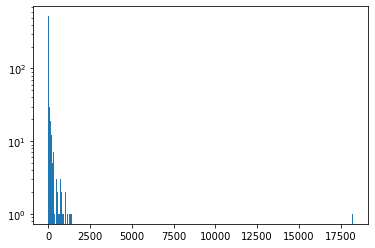

In [1444]:
hist(tur,1000)
yscale('log')


In [22]:
df_composite["turgidity"] = tur

(array([875.,  62.,  21.,  17.,   8.,   3.,   4.,   3.,   1.,   0.,   2.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([    0.  ,   182.24,   364.48,   546.72,   728.96,   911.2 ,
         1093.44,  1275.68,  1457.92,  1640.16,  1822.4 ,  2004.64,
         2186.88,  2369.12,  2551.36,  2733.6 ,  2915.84,  3098.08,
         3280.32,  3462.56,  3644.8 ,  3827.04,  4009.28,  4191.52,
         4373.76,  4556.  ,  4738.24,  4920.48

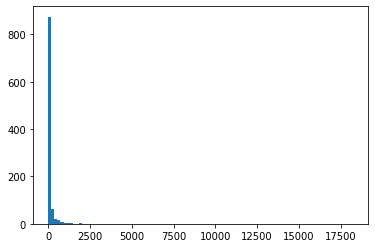

In [1446]:
hist(tur,100)

In [23]:
x = df_composite.click_length.to_numpy()
y = df_composite.turgidity.to_numpy()

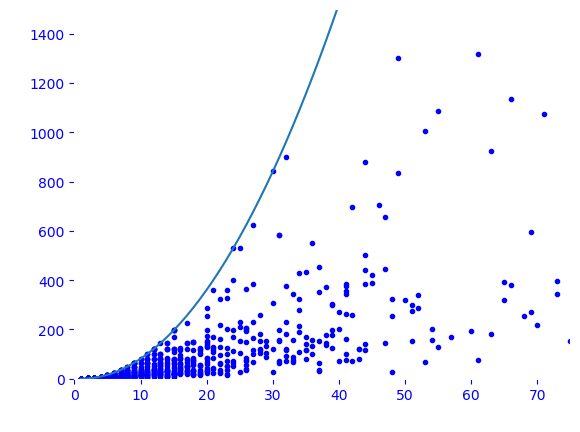

In [74]:
fig, ax = subplots()

ax.scatter(x,y,marker='.',facecolor='b')
#xscale('log')
#yscale('log')
ax.set_ylim([0,1500])
ax.set_xlim([0,75])
ax.spines['bottom'].set_color('#ffffff')
ax.spines['top'].set_color('#ffffff') 
ax.spines['right'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.tick_params(axis='x', colors='b')
ax.tick_params(axis='y', colors='b')
ax.yaxis.label.set_color('w')
ax.xaxis.label.set_color('w')
ax.plot(arange(1,70,1),[(xi-1)**2 for xi in arange(1,70,1)])
ax.set_ylabel('turgidity')
ax.set_xlabel('number of clicks')
fig.savefig('turgidity_pur.pdf',transparent=True)

In [51]:
rcParams.update(rcParamsDefault)

In [57]:
# Turgidity analysis with non buyers
random_1k = users[:1000]

In [58]:
clicks_down = clicks.loc[clicks['user_ID'].isin(random_1k)].sort_values(by='request_time')

In [59]:
click_stream =[]
product_stream =[]
for i in random_1k[:1000]:
    ccc = clicks_down[clicks_down.user_ID==i]
    click_stream.append(ccc.request_time.to_numpy())
    product_stream.append(ccc.sku_ID.to_numpy()) 

In [60]:
df_composite = pd.DataFrame(transpose([random_1k[:1000],click_stream,product_stream]),index = arange(0,1000,1),columns=['user','clicks','prods'])

In [61]:
df_composite = df_composite.drop(index=0)

In [62]:
c_len = [len(xi) for xi in df_composite.clicks]    


In [63]:
df_composite["click_len"] = c_len

In [64]:
tur=[]
for i in random_1k[1:1000]:
    a = df_composite[df_composite.user ==i].prods.to_numpy()[0]
    a.sort()
    revisits = [(len(list(group))-1)**2.0 for key, group in groupby(a)]
    tur.append(sum(revisits))

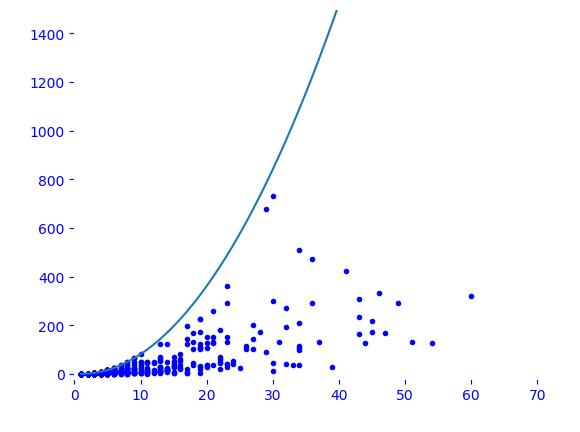

In [71]:
fig, ax = subplots()

ax.scatter(c_len,tur,marker='.',facecolor='b')
#xscale('log')
#yscale('log')
ax.set_ylim([-20,1500])
ax.set_xlim([0,75])
ax.spines['bottom'].set_color('#ffffff')
ax.spines['top'].set_color('#ffffff') 
ax.spines['right'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.tick_params(axis='x', colors='b')
ax.tick_params(axis='y', colors='b')
ax.yaxis.label.set_color('w')
ax.xaxis.label.set_color('w')
ax.plot(arange(1,70,1),[(xi-1)**2 for xi in arange(1,70,1)])

ax.set_ylabel('turgidity')
ax.set_xlabel('number of clicks')
fig.savefig('turgidity_random.pdf',transparent=True)


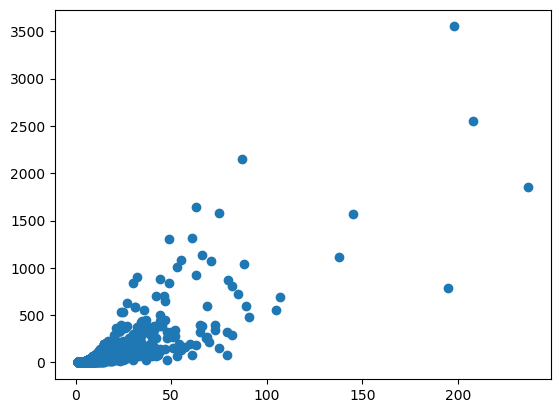

In [72]:
scatter(x,y)

In [443]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x)
    return(unique_list)

### Pickling important data sets

In [218]:
df.to_pickle("./first_100000.pkl")  #pickled the 1d clickstream data of the first 100,000 users

In [ ]:
c.to_pickle("./sorted_user_ID_reqtime.pkl") #pickled the entire clicks dataset sorted by user_ID